# Baseline

In [3]:
# EEG Feature Selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from scipy import signal
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from mne.decoding import CSP
import json
import os
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics as M
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

# Set random seed for reproducibility
np.random.seed(42)

In [4]:
def loadData(
    fold_name: str,
    kfold_dict: dict,
    data_path: str,
    set_suffix: str = "_task-eyesclosed_eeg.set"
):
    """
    Load MNE Raw objects for all training and validation subjects in one fold.
    
    Parameters
    ----------
    fold_name : str
        e.g. 'fold_1', 'fold_2', etc., as found in kfold_dict.
    kfold_dict : dict
        The JSON structure loaded from kfold_splits.json
    data_path : str
        Base directory where the sub-XXX folders are found.
        Typically something like '/path/to/dataset/derivatives'
        if .set files live in a derivatives folder.
    set_suffix : str
        The filename pattern for the EEGLAB .set file, 
        e.g. '_task-eyesclosed_eeg.set'. Adjust as needed.
    
    Returns
    -------
    train_raws : list
        List of mne.io.Raw objects for all training subjects in this fold.
    val_raws : list
        List of mne.io.Raw objects for all validation subjects in this fold.
    """

    fold_data = kfold_dict[fold_name]
    train_subjects = fold_data["train"]
    val_subjects   = fold_data["validation"]

    train_raws = []
    val_raws   = []

    # 1) Load all training subjects
    for subj_id in train_subjects:
        # Construct the filepath to the .set file
        subject_folder = os.path.join(data_path, subj_id, "eeg")
        set_filename   = f"{subj_id}{set_suffix}"
        set_filepath   = os.path.join(subject_folder, set_filename)

        print(f"[{fold_name}] Loading TRAIN subject: {subj_id} -> {set_filepath}")
        raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
        train_raws.append(raw_obj)

    # 2) Load all validation subjects
    for subj_id in val_subjects:
        subject_folder = os.path.join(data_path, subj_id, "eeg")
        set_filename   = f"{subj_id}{set_suffix}"
        set_filepath   = os.path.join(subject_folder, set_filename)

        print(f"[{fold_name}] Loading VAL subject: {subj_id} -> {set_filepath}")
        raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
        val_raws.append(raw_obj)

    return train_raws, val_raws

# Example usage:
if __name__ == "__main__":
    # 0) Load kfold_splits.json
    with open("alzheimers_vs_healthy_splits.json", "r") as f:
        kfold_splits = json.load(f)

    # 1) Choose your data path (where the sub-XXX folders live)
    #    If your .set files are stored in a 'derivatives' folder, use that:
    data_dir = "dataset/derivatives"

    # 2) Load data for fold_1 (as an example)
    fold_name = "fold_1"
    train_raws, val_raws = loadData(
        fold_name=fold_name,
        kfold_dict=kfold_splits,
        data_path=data_dir,
        set_suffix="_task-eyesclosed_eeg.set"
    )

    # Now you have 'train_raws' and 'val_raws' as lists of MNE Raw objects.
    # You can proceed with feature selection or further processing.


[fold_1] Loading TRAIN subject: sub-021 -> dataset/derivatives/sub-021/eeg/sub-021_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-026 -> dataset/derivatives/sub-026/eeg/sub-026_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-019 -> dataset/derivatives/sub-019/eeg/sub-019_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-010 -> dataset/derivatives/sub-010/eeg/sub-010_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-017 -> dataset/derivatives/sub-017/eeg/sub-017_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-028 -> dataset/derivatives/sub-028/eeg/sub-028_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-016 -> dataset/derivatives/sub-016/eeg/sub-016_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-029 -> dataset/derivatives/sub-029/eeg/sub-029_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-011 -> dataset/derivatives/sub-011/eeg/sub-011_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-027 -> dataset/derivatives/sub-027/eeg/sub-027_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-018 -> dataset/derivatives/sub-018/eeg/sub-018_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-020 -> dataset/derivatives/sub-020/eeg/sub-020_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-033 -> dataset/derivatives/sub-033/eeg/sub-033_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-034 -> dataset/derivatives/sub-034/eeg/sub-034_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-035 -> dataset/derivatives/sub-035/eeg/sub-035_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-004 -> dataset/derivatives/sub-004/eeg/sub-004_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-025 -> dataset/derivatives/sub-025/eeg/sub-025_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-014 -> dataset/derivatives/sub-014/eeg/sub-014_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-012 -> dataset/derivatives/sub-012/eeg/sub-012_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-015 -> dataset/derivatives/sub-015/eeg/sub-015_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-023 -> dataset/derivatives/sub-023/eeg/sub-023_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-024 -> dataset/derivatives/sub-024/eeg/sub-024_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-006 -> dataset/derivatives/sub-006/eeg/sub-006_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-001 -> dataset/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-008 -> dataset/derivatives/sub-008/eeg/sub-008_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-031 -> dataset/derivatives/sub-031/eeg/sub-031_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-036 -> dataset/derivatives/sub-036/eeg/sub-036_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-007 -> dataset/derivatives/sub-007/eeg/sub-007_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-043 -> dataset/derivatives/sub-043/eeg/sub-043_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-044 -> dataset/derivatives/sub-044/eeg/sub-044_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-042 -> dataset/derivatives/sub-042/eeg/sub-042_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-060 -> dataset/derivatives/sub-060/eeg/sub-060_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-058 -> dataset/derivatives/sub-058/eeg/sub-058_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-051 -> dataset/derivatives/sub-051/eeg/sub-051_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-056 -> dataset/derivatives/sub-056/eeg/sub-056_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-057 -> dataset/derivatives/sub-057/eeg/sub-057_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-050 -> dataset/derivatives/sub-050/eeg/sub-050_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-059 -> dataset/derivatives/sub-059/eeg/sub-059_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-061 -> dataset/derivatives/sub-061/eeg/sub-061_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-040 -> dataset/derivatives/sub-040/eeg/sub-040_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-049 -> dataset/derivatives/sub-049/eeg/sub-049_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-048 -> dataset/derivatives/sub-048/eeg/sub-048_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-046 -> dataset/derivatives/sub-046/eeg/sub-046_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-039 -> dataset/derivatives/sub-039/eeg/sub-039_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-037 -> dataset/derivatives/sub-037/eeg/sub-037_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-064 -> dataset/derivatives/sub-064/eeg/sub-064_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-063 -> dataset/derivatives/sub-063/eeg/sub-063_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-038 -> dataset/derivatives/sub-038/eeg/sub-038_task-eyesclosed_eeg.set

<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)



[fold_1] Loading TRAIN subject: sub-053 -> dataset/derivatives/sub-053/eeg/sub-053_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-054 -> dataset/derivatives/sub-054/eeg/sub-054_task-eyesclosed_eeg.set
[fold_1] Loading TRAIN subject: sub-062 -> dataset/derivatives/sub-062/eeg/sub-062_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading TRAIN subject: sub-065 -> dataset/derivatives/sub-065/eeg/sub-065_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-002 -> dataset/derivatives/sub-002/eeg/sub-002_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-005 -> dataset/derivatives/sub-005/eeg/sub-005_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-032 -> dataset/derivatives/sub-032/eeg/sub-032_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-003 -> dataset/derivatives/sub-003/eeg/sub-003_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-022 -> dataset/derivatives/sub-022/eeg/sub-022_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-013 -> dataset/derivatives/sub-013/eeg/sub-013_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-030 -> dataset/derivatives/sub-030/eeg/sub-030_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-009 -> dataset/derivatives/sub-009/eeg/sub-009_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-045 -> dataset/derivatives/sub-045/eeg/sub-045_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-047 -> dataset/derivatives/sub-047/eeg/sub-047_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-041 -> dataset/derivatives/sub-041/eeg/sub-041_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)
<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


[fold_1] Loading VAL subject: sub-055 -> dataset/derivatives/sub-055/eeg/sub-055_task-eyesclosed_eeg.set
[fold_1] Loading VAL subject: sub-052 -> dataset/derivatives/sub-052/eeg/sub-052_task-eyesclosed_eeg.set


<ipython-input-4-921ffc81fc19>:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_obj = mne.io.read_raw_eeglab(set_filepath, preload=True)


In [5]:
# 1. Load the participants file.
participants = pd.read_csv("dataset/participants.tsv", sep="\t")
print(participants.head())

# 2. Create a mapping from participant_id to Group.
group_dict = dict(zip(participants['participant_id'], participants['Group']))
print("Group mapping:", group_dict)

# 3. Create a mapping from group labels to numeric labels.
#    For example, if your groups are "A", "B", "C", this code will assign them 0, 1, 2.
unique_groups = participants['Group'].unique()
print("Unique groups:", unique_groups)
label_map = {group: i for i, group in enumerate(unique_groups)}
print("Label map:", label_map)

# 4. Assume that train_raws is your list of Raw objects.
#    You need a list of subject IDs corresponding to train_raws.
#    For example, if you haven't stored the subject IDs in raw.info, you can manually create one:
train_subject_ids = [f"sub-{i:03d}" for i in range(1, len(train_raws)+1)]
val_subject_ids = [f"sub-{i:03d}" for i in range(1, len(val_raws)+1)]
# Alternatively, if raw.info already contains subject info, extract it:
# train_subject_ids = [raw.info.get('subject_id', f"sub-{i:03d}") for i, raw in enumerate(train_raws)]

# 5. Define a function to extract epochs from a Raw object.
def extract_epochs_from_raw(raw, duration=1.0, tmin=0.0):
    """
    Extract epochs from a Raw object. If no valid events (other than 'boundary') are found,
    create fixed-length epochs.
    """
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    if events.size == 0:
        print(f"No valid events for subject {raw.info.get('subject_id', 'unknown')}. Creating fixed-length epochs.")
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, overlap=0, preload=True)
    else:
        tmax = tmin + duration
        epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax,
                            baseline=None, preload=True, verbose=False)
    return epochs

# 6. Loop over each training subject, extract epochs, and assign the clinical label.
all_epochs_list = []
all_labels_list = []

for i, raw in enumerate(train_raws):
    subject_id = train_subject_ids[i]
    if subject_id not in group_dict:
        raise ValueError(f"Group for subject {subject_id} not found in participants.tsv")
    
    group = group_dict[subject_id]
    label = label_map[group]
    
    # Extract epochs (using fixed-length if necessary)
    epochs = extract_epochs_from_raw(raw, duration=1.0)
    
    # Ensure consistent epoch length by cropping each epoch to exactly duration seconds.
    sfreq = raw.info['sfreq']
    n_samples_expected = int(sfreq * 1.0)
    data = epochs.get_data()[:, :, :n_samples_expected]
    new_epochs = mne.EpochsArray(data, epochs.info, events=epochs.events, event_id=epochs.event_id)
    
    all_epochs_list.append(new_epochs)
    # Create an array of labels for all epochs from this subject.
    subject_labels = np.full(new_epochs.get_data().shape[0], label)
    all_labels_list.append(subject_labels)

# 7. Concatenate epochs and labels from all subjects.
epochs_all = mne.concatenate_epochs(all_epochs_list)
X_train = epochs_all.get_data()       # shape: (n_total_trials, n_channels, n_samples)
y_train = np.concatenate(all_labels_list)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels in y_train:", np.unique(y_train))

for i, raw in enumerate(val_raws):
    subject_id = val_subject_ids[i]
    if subject_id not in group_dict:
        raise ValueError(f"Group for subject {subject_id} not found in participants.tsv")
    
    group = group_dict[subject_id]
    label = label_map[group]
    
    # Extract epochs (using fixed-length if necessary)
    epochs = extract_epochs_from_raw(raw, duration=1.0)
    
    # Ensure consistent epoch length by cropping each epoch to exactly duration seconds.
    sfreq = raw.info['sfreq']
    n_samples_expected = int(sfreq * 1.0)
    data = epochs.get_data()[:, :, :n_samples_expected]
    new_epochs = mne.EpochsArray(data, epochs.info, events=epochs.events, event_id=epochs.event_id)
    
    all_epochs_list.append(new_epochs)
    # Create an array of labels for all epochs from this subject.
    subject_labels = np.full(new_epochs.get_data().shape[0], label)
    all_labels_list.append(subject_labels)

epochs_all = mne.concatenate_epochs(all_epochs_list)
X_val = epochs_all.get_data()       # shape: (n_total_trials, n_channels, n_samples)
y_val = np.concatenate(all_labels_list)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("Unique labels in y_val:", np.unique(y_val))

  participant_id Gender  Age Group  MMSE
0        sub-001      F   57     A    16
1        sub-002      F   78     A    22
2        sub-003      M   70     A    14
3        sub-004      F   67     A    20
4        sub-005      M   70     A    22
Group mapping: {'sub-001': 'A', 'sub-002': 'A', 'sub-003': 'A', 'sub-004': 'A', 'sub-005': 'A', 'sub-006': 'A', 'sub-007': 'A', 'sub-008': 'A', 'sub-009': 'A', 'sub-010': 'A', 'sub-011': 'A', 'sub-012': 'A', 'sub-013': 'A', 'sub-014': 'A', 'sub-015': 'A', 'sub-016': 'A', 'sub-017': 'A', 'sub-018': 'A', 'sub-019': 'A', 'sub-020': 'A', 'sub-021': 'A', 'sub-022': 'A', 'sub-023': 'A', 'sub-024': 'A', 'sub-025': 'A', 'sub-026': 'A', 'sub-027': 'A', 'sub-028': 'A', 'sub-029': 'A', 'sub-030': 'A', 'sub-031': 'A', 'sub-032': 'A', 'sub-033': 'A', 'sub-034': 'A', 'sub-035': 'A', 'sub-036': 'A', 'sub-037': 'C', 'sub-038': 'C', 'sub-039': 'C', 'sub-040': 'C', 'sub-041': 'C', 'sub-042': 'C', 'sub-043': 'C', 'sub-044': 'C', 'sub-045': 'C', 'sub-046': 'C', 's

<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of

No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
869 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 869 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
869 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection item

<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
599 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 599 events and 500 original time points ...


<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of

0 bad epochs dropped
Not setting metadata
599 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
829 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 829 events and 500 original time points ...


<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of

0 bad epochs dropped
Not setting metadata
829 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 881 events and 500 original time points ...


<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


0 bad epochs dropped
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
796 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 796 events and 500 original time points ...


<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of

0 bad epochs dropped
Not setting metadata
796 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject un

<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of

0 bad epochs dropped
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
884 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of

Using data from preloaded Raw for 884 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
884 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-5-396ce0feb410>:58: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:63: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


Not setting metadata
5974 matching events found
No baseline correction applied
X_train shape: (5974, 19, 500)
y_train shape: (5974,)
Unique labels in y_train: [0 1]
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
793 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 793 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
793 matching events found
No baseline correction applied
0 projection items activated
No valid events for subject unknown. Creating fixed-length epochs.
Not setting metadata
804 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 804 events and 500 original time points ...


<ipython-input-5-396ce0feb410>:68: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = epochs_all.get_data()       # shape: (n_total_trials, n_channels, n_samples)
<ipython-input-5-396ce0feb410>:88: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:93: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)


0 bad epochs dropped
Not setting metadata
804 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
34 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching

<ipython-input-5-396ce0feb410>:88: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:93: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:88: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()[:, :, :n_samples_expected]
<ipython-input-5-396ce0feb410>:93: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  subject_labels = np.full(new_epochs.get_data().shape[0], label)
<ipython-input-5-396ce0feb410>:88: FutureWarning: The current default of

Not setting metadata
7629 matching events found
No baseline correction applied
X_val shape: (7629, 19, 500)
y_val shape: (7629,)
Unique labels in y_val: [0 1]


<ipython-input-5-396ce0feb410>:97: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_val = epochs_all.get_data()       # shape: (n_total_trials, n_channels, n_samples)


Class labels: [0 1]
Class counts: [4209 1765]
Balance ratio: 0.42 (1.0 is perfectly balanced)


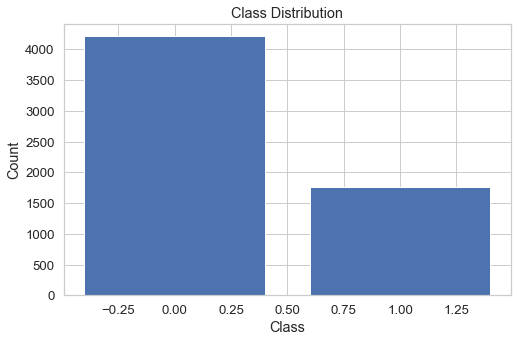

Class 0: 70.5%
Class 1: 29.5%


In [6]:
labels, counts = np.unique(y_train, return_counts=True)
balance_ratio = min(counts) / max(counts)

print(f"Class labels: {labels}")
print(f"Class counts: {counts}")
print(f"Balance ratio: {balance_ratio:.2f} (1.0 is perfectly balanced)")

# Visualize the balance
plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Calculate percentage
percentages = counts / np.sum(counts) * 100
for label, percentage in zip(labels, percentages):
    print(f"Class {label}: {percentage:.1f}%")

In [7]:
# Check class balance in training data
unique_labels, counts = np.unique(y_train, return_counts=True)
print("Class distribution:", dict(zip(unique_labels, counts)))
print("Class percentages:", {label: f"{count/len(y_train)*100:.1f}%" for label, count in zip(unique_labels, counts)})

# Create mapping to original group labels (for better visualization)
reverse_label_map = {i: group for group, i in label_map.items()}
print("Label mapping:", reverse_label_map)

# Prepare data - X_train is (n_trials, n_channels, n_timepoints)
n_trials = X_train.shape[0]
X_train_flat = X_train.reshape(n_trials, -1)  # Flatten channels and timepoints
print(f"Data shape after flattening: {X_train_flat.shape}")



Class distribution: {0: 4209, 1: 1765}
Class percentages: {0: '70.5%', 1: '29.5%'}
Label mapping: {0: 'A', 1: 'C', 2: 'F'}
Data shape after flattening: (5974, 9500)


In [8]:
# Create pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep components that explain 95% of variance
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42))
])
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train_flat, y_train, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation accuracy: 0.4977 ± 0.0080


In [9]:
# Get predictions from cross-validation for detailed metrics
y_pred_cv = cross_val_predict(pipeline, X_train_flat, y_train, cv=cv)
y_prob_cv = cross_val_predict(pipeline, X_train_flat, y_train, cv=cv, method='predict_proba')

# Print classification report
print("\nCross-validation Classification Report:")
print(M.classification_report(y_train, y_pred_cv, target_names=[reverse_label_map[i] for i in unique_labels]))




Cross-validation Classification Report:
              precision    recall  f1-score   support

           A       0.70      0.51      0.59      4209
           C       0.29      0.47      0.35      1765

    accuracy                           0.50      5974
   macro avg       0.49      0.49      0.47      5974
weighted avg       0.57      0.50      0.52      5974



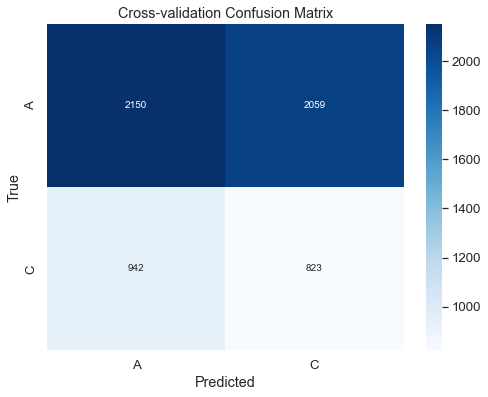

In [10]:
# Compute confusion matrix
cm = M.confusion_matrix(y_train, y_pred_cv)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[reverse_label_map[i] for i in unique_labels], 
            yticklabels=[reverse_label_map[i] for i in unique_labels])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Cross-validation Confusion Matrix')
plt.show()

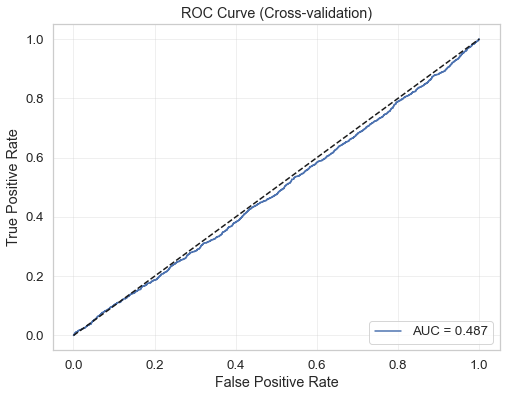

In [11]:
# For binary classification, compute ROC curve and AUC
if len(unique_labels) == 2:
    # Get probability of the positive class (class 1)
    positive_class_idx = 1 if 1 in unique_labels else unique_labels[1]
    prob_pos_class = y_prob_cv[:, list(unique_labels).index(positive_class_idx)]
    
    fpr, tpr, _ = M.roc_curve(y_train, prob_pos_class)
    auc = M.roc_auc_score(y_train, prob_pos_class)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Cross-validation)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


Model trained on all data


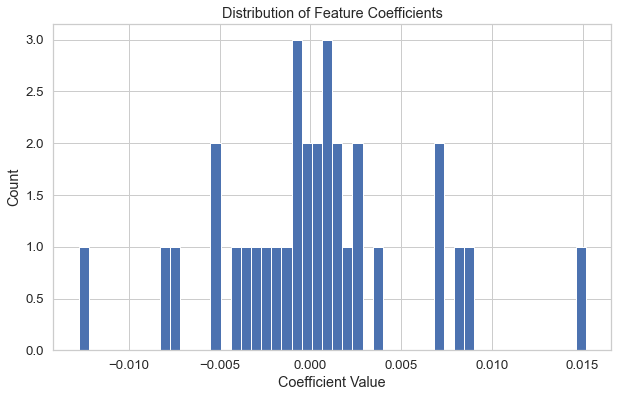

In [12]:
# Train on all data and save the model
final_model = pipeline.fit(X_train_flat, y_train)
print("Model trained on all data")

# Get feature importances (for logistic regression, the coefficients)
if hasattr(final_model['classifier'], 'coef_'):
    # For binary classification
    coefficients = final_model['classifier'].coef_[0]
    
    # We can't interpret feature names when using all flattened data
    # But we can see the magnitude of coefficients
    plt.figure(figsize=(10, 6))
    plt.hist(coefficients, bins=50)
    plt.title('Distribution of Feature Coefficients')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Count')
    plt.show()